In [1]:
import torch
import torch.nn as nn

import time
import numpy as np
import skimage.color as color
import matplotlib.pyplot as plt
import cv2

from collections import OrderedDict
from torch.utils.data import DataLoader
from torchvision import transforms as tf, datasets as ds
from torchvision.utils import make_grid

In [2]:
data_root_color = 'C:/Datasets/Places365/train'
workers = 0
batch_size = 20
image_size = 256
nc = 3      # Number of output color channels.
nz = 1      # Number of input color channels (Latent vector).
ngf = 64    # Depth of feature map, carried through the generator(G).
ndf = 64    # Depth of feature map, carried through the discriminator(D).
lr = 2e-4
beta1 = 5e-1
ngpu = 1
weight_decay = 1e-2 # Lambda (hyper-parameter regularization)

In [3]:
is_cuda_available = torch.cuda.is_available()
device = torch.device('cuda:0' if is_cuda_available and ngpu > 0 else 'cpu')
device

device(type='cuda', index=0)

In [4]:
image_transform = {
    "rgb": tf.Compose([
        tf.Resize(image_size),
        tf.CenterCrop(image_size),
        tf.ToTensor()
        # tf.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        # tf.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

In [5]:
color_set = ds.ImageFolder(root=data_root_color, transform=image_transform['rgb'])

In [6]:
color_loader = DataLoader(color_set, batch_size, shuffle=False, num_workers=workers, pin_memory=is_cuda_available)

Text(0.5, 1.0, 'COLOR IMAGE SAMPLE')

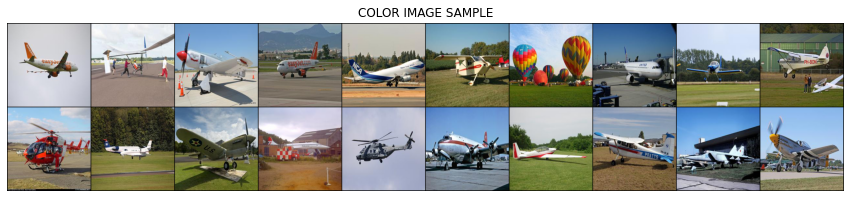

In [7]:
c_im = next(iter(color_loader))

c_grid = make_grid(c_im[0], nrow=10, normalize=True)

plt.figure(figsize=(15, 14))
plt.imshow(np.transpose(c_grid, axes=(1, 2, 0)))
plt.axis('off')
plt.title('COLOR IMAGE SAMPLE')

In [8]:
class RGB2LAB(object):

    def __call__(self, image):
        """
        :param image: PIL/NumPy image to be converted.
        :return: the LAB color channel image.
        """
        return color.rgb2lab(np.array(image))

class RGB2L(object):

    def __call__(self, image):
        """
        :param image: PIL/NumPy image to be converted.
        :return: the LAB color channel image.
        """
        return color.rgb2lab(np.array(image))[:, :, 0]


In [9]:
def lab2rgb(image, dim=None):
    """
    :param image is a single Lab image the shape of (X, y, 3)
    :param dim to define the color-channel dimension.
    """
    image = np.transpose(image, axes=(1, 2, 0))

    if dim is not None:
        z = np.zeros_like(image)
        if dim != 0:
            z[:, :, 0] = 80  # Increase the brightness to see other color channels(a & b).

        z[:, :, dim] = image[:, :, dim]
        return color.lab2rgb(z)
    else:
        return color.lab2rgb(image)

In [10]:
image_transform['lab'] = tf.Compose([
    tf.Resize(image_size),
    tf.CenterCrop(image_size),
    RGB2LAB(),
    tf.ToTensor()
    # tf.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    # tf.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image_transform['l'] = tf.Compose([
    tf.Resize(image_size),
    tf.CenterCrop(image_size),
    RGB2L(),
    tf.ToTensor()
    # tf.Normalize(mean=[0.5], std=[0.5])
    # tf.Normalize(mean=[0.485], std=[0.229])
])

In [11]:
lab_set = ds.ImageFolder(root=data_root_color, transform=image_transform['lab'])
lab_loader = DataLoader(lab_set, batch_size, num_workers=workers, pin_memory=is_cuda_available)

In [12]:
l_set = ds.ImageFolder(root=data_root_color, transform=image_transform['l'])
l_loader = DataLoader(l_set, batch_size, num_workers=workers, pin_memory=is_cuda_available)

## Colorizing Images with Supervised Learning

In [13]:
class ColorNet(nn.Module):

    def __init__(self, in_channels=1, out_channels=3, n_layers=(32, 64, 64, 32, 16, 8)):
        super(ColorNet, self).__init__()

        layers = []
        prev = in_channels

        for n in n_layers:
            layers.append(nn.Conv2d(in_channels=prev, out_channels=n, kernel_size=4, stride=2, padding=1)),
            layers.append(nn.BatchNorm2d(n)),
            layers.append(nn.ReLU())
            layers.append(nn.Upsample(scale_factor=2.))
            prev = n

        layers.append(nn.Conv2d(in_channels=prev, out_channels=out_channels, kernel_size=3, stride=1, padding=1))

        self.main = nn.Sequential(*layers)

    def forward(self, x):
        return self.main(x)


colorNet = ColorNet().to(device).double()
colorNet

ColorNet(
  (main): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Upsample(scale_factor=2.0, mode=nearest)
    (4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Upsample(scale_factor=2.0, mode=nearest)
    (8): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Upsample(scale_factor=2.0, mode=nearest)
    (12): Conv2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Upsample(scale_factor=2.0, mode=nearest)
    (16): Conv2d(32, 16, kernel_size=(4, 4)

In [14]:
count = 0
for param in colorNet.parameters():
    count += param.numel()

count

142691

In [0]:
losses = []

torch.cuda.empty_cache()

criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(colorNet.parameters(), lr=lr)

epochs = 5
batch_limit = 1000

start = time.time()

for i in range(epochs):
    i += 1

    for batch, (X, y) in enumerate(zip(l_loader, lab_loader)):
        batch += 1

        optimizer.zero_grad()

        X = X[0].to(device)
        y = y[0].to(device)

        y_pred = colorNet(X)
        loss = criterion(y_pred, y)

        if batch == 1 or batch % 100 == 0:
            losses.append(loss)
            print(f'Epoch: {i}/{epochs}, Batch: {batch}/{batch_limit} => Loss: {loss}')

        loss.backward()
        optimizer.step()

        if batch == batch_limit:
            break

duration = time.time() - start
print(f'Duration to execute: {duration / 60:0.4f} minutes')

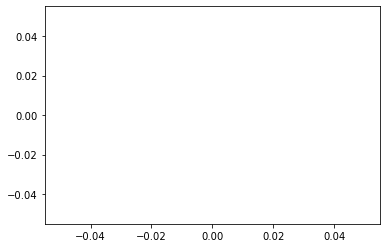

In [24]:
plt.plot(losses)

In [16]:
PATH = '../../state_dict/colorizing_net.pth'

# torch.save(colorNet.state_dict(), PATH)
colorNet.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [15]:
img_size = (image_size, image_size)

@torch.no_grad()
def view(image):

    colorNet.eval()

    image = colorNet(image.to(device))
    image = lab2rgb(image.cpu().numpy().reshape(-1, *img_size))

    return image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'B CHANNEL SAMPLE')

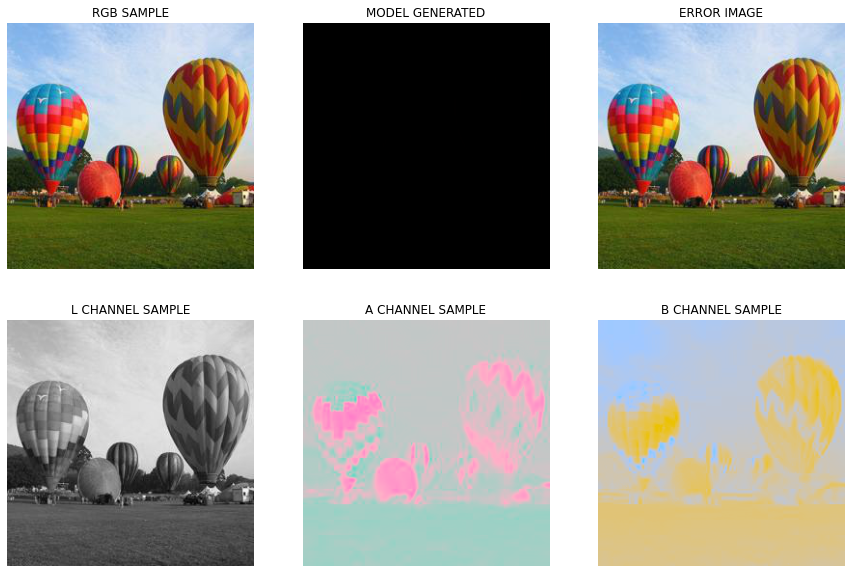

In [16]:
IMG_INDEX = 6

lab_im = next(iter(lab_loader))[0][IMG_INDEX]
l_im = next(iter(l_loader))[0]

plt.figure(figsize=(15, 10))

org = np.transpose(c_im[0][IMG_INDEX], axes=(1, 2, 0))

plt.subplot(231)
plt.imshow(org)
plt.axis('off')
plt.title('RGB SAMPLE')

img = l_im[IMG_INDEX]
img = view(img.view(-1, 1, *img_size).double())

plt.subplot(232)
plt.imshow(img)
plt.axis('off')
plt.title('MODEL GENERATED')

error = np.subtract(img, org) * -1

plt.subplot(233)
plt.imshow(error)
plt.axis('off')
plt.title('ERROR IMAGE')

plt.subplot(234)
plt.imshow(lab2rgb(lab_im, 0))
plt.axis('off')
plt.title('L CHANNEL SAMPLE')

plt.subplot(235)
plt.imshow(lab2rgb(lab_im, 1))
plt.axis('off')
plt.title('A CHANNEL SAMPLE')

plt.subplot(236)
plt.imshow(lab2rgb(lab_im, 2))
plt.axis('off')
plt.title('B CHANNEL SAMPLE')

## DCGAN to colorize grayscale images - Unsupervised Learning

In [17]:
def weights_init(m):
    """
    Custom weights initialization for the input tensor call on Generator and Discriminator
    networks' weights of Convolutional, ConvolutionsTranspose and BatchNormalization layers.

    Per the DCGAN paper, all the model weights shall be randomly initialized from a normal
    distribution with mean=0.0 and std=0.02.

    :param m: Network layer object to derive and update weights randomly.
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, mean=0., std=.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, mean=1., std=.02)
        nn.init.constant_(m.bias.data, val=0)

In [18]:
class Generator(nn.Module):

    def __init__(self, in_channels=nz, out_channels=nc, pad=(0, 1, 0, 1)):
        super(Generator, self).__init__()

        # Convolutional Layers (ENCODE)
        self.encode = nn.Sequential(OrderedDict([
            ('conv1', nn.Sequential(
                # Input size -> (nz) x 256 x 256
                nn.Conv2d(in_channels=in_channels, out_channels=ngf, kernel_size=1, stride=1, bias=False),
                nn.LeakyReLU(negative_slope=0.2)
            )),
            ('conv2', nn.Sequential(
                #State size -> (ngf) x 256 x 256
                nn.Conv2d(in_channels=ngf, out_channels=ngf, kernel_size=4, stride=2, bias=False),
                nn.ReplicationPad2d(padding=pad),
                nn.BatchNorm2d(ngf),
                nn.LeakyReLU(negative_slope=0.2)
            )),
            ('conv3', nn.Sequential(
                # State size -> (ngf) x 128 x 128
                nn.Conv2d(in_channels=ngf, out_channels=ngf * 2, kernel_size=4, stride=2, bias=False),
                nn.ReplicationPad2d(padding=pad),
                nn.BatchNorm2d(ngf * 2),
                nn.LeakyReLU(negative_slope=0.2)
            )),
            ('conv4', nn.Sequential(
                # State size -> (ngf * 2) x 64 x 64
                nn.Conv2d(in_channels=ngf * 2, out_channels=ngf * 4, kernel_size=4, stride=2, bias=False),
                nn.ReplicationPad2d(padding=pad),
                nn.BatchNorm2d(ngf * 4),
                nn.LeakyReLU(negative_slope=0.2)
            )),
            ('conv5', nn.Sequential(
                # State size -> (ngf * 4) x 32 x 32
                nn.Conv2d(in_channels=ngf * 4, out_channels=ngf * 8, kernel_size=4, stride=2, bias=False),
                nn.ReplicationPad2d(padding=pad),
                nn.BatchNorm2d(ngf * 8),
                nn.LeakyReLU(negative_slope=0.2)
            )),
            ('conv6', nn.Sequential(
                # State size -> (ngf * 8) x 16 x 16
                nn.Conv2d(in_channels=ngf * 8, out_channels=ngf * 8, kernel_size=4, stride=2, bias=False),
                nn.ReplicationPad2d(padding=pad),
                nn.BatchNorm2d(ngf * 8),
                nn.LeakyReLU(negative_slope=0.2)
            )),
            ('conv7', nn.Sequential(
                # State size -> (ngf * 8) x 8 x 8
                nn.Conv2d(in_channels=ngf * 8, out_channels=ngf * 8, kernel_size=4, stride=2, bias=False),
                nn.ReplicationPad2d(padding=pad),
                nn.BatchNorm2d(ngf * 8),
                nn.LeakyReLU(negative_slope=0.2)
            )),
            ('conv8', nn.Sequential(
                # State size -> (ngf * 8) x 4 x 4
                nn.Conv2d(in_channels=ngf * 8, out_channels=ngf * 8, kernel_size=4, stride=2, bias=False),
                nn.BatchNorm2d(ngf * 8),
                nn.LeakyReLU(negative_slope=0.2)
                # State size -> (ngf * 8) x 1 x 1
            ))
        ]))

        self.decode = nn.Sequential(OrderedDict([
            ('conv1', nn.Sequential(
                # Input size -> (ngf * 8) x 2 x 2
                nn.ConvTranspose2d(in_channels=ngf * 8, out_channels=ngf * 8, kernel_size=4, stride=2, bias=False),
                nn.BatchNorm2d(ngf * 8),
                nn.ReLU(),
                nn.Dropout2d(p=0.5)
            )),
            ('conv2', nn.Sequential(
                # State size -> (ngf * 8) x 4 x 4
                nn.ConvTranspose2d(in_channels=ngf * 16, out_channels=ngf * 8, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(ngf * 8),
                nn.ReLU(),
                nn.Dropout2d(p=0.5)
            )),
            ('conv3', nn.Sequential(
                # State size -> (ngf * 8) x 8 x 8
                nn.ConvTranspose2d(in_channels=ngf * 16, out_channels=ngf * 8, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(ngf * 8),
                nn.ReLU()
            )),
            ('conv4', nn.Sequential(
                # State size -> (ngf * 8) x 16 x 16
                nn.ConvTranspose2d(in_channels=ngf * 16, out_channels=ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(ngf * 4),
                nn.ReLU()
            )),
            ('conv5', nn.Sequential(
                # State size -> (ngf * 4) x 32 x 32
                nn.ConvTranspose2d(in_channels=ngf * 8, out_channels=ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(ngf * 2),
                nn.ReLU()
            )),
            ('conv6', nn.Sequential(
                # State size -> (ngf * 2) x 64 x 64
                nn.ConvTranspose2d(in_channels=ngf * 4, out_channels=ngf, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(ngf),
                nn.ReLU()
            )),
            ('conv7', nn.Sequential(
                # State size -> (ngf) x 128 x 128
                nn.ConvTranspose2d(in_channels=ngf * 2, out_channels=ngf, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(ngf),
                nn.ReLU()
            )),
            ('parametric', nn.Sequential(
                # State size -> (ngf) x 256 x 256
                nn.Conv2d(in_channels=ngf * 2, out_channels=out_channels, kernel_size=1, stride=1, bias=False),
                nn.Tanh()
                # State size -> (ngf) x 256 x 256
            ))
        ]))

        self.encode_children = dict(self.encode.named_children())
        self.decode_children = dict(self.decode.named_children())

    def forward(self, x):

        conv1 = self.encode_children['conv1'](x)
        conv2 = self.encode_children['conv2'](conv1)
        conv3 = self.encode_children['conv3'](conv2)
        conv4 = self.encode_children['conv4'](conv3)
        conv5 = self.encode_children['conv5'](conv4)
        conv6 = self.encode_children['conv6'](conv5)
        conv7 = self.encode_children['conv7'](conv6)
        conv8 = self.encode_children['conv8'](conv7)

        conv9 = torch.cat([self.decode_children['conv1'](conv8),conv7], dim=1)
        conv10 = torch.cat([self.decode_children['conv2'](conv9), conv6], dim=1)
        conv11 = torch.cat([self.decode_children['conv3'](conv10), conv5], dim=1)
        conv12 = torch.cat([self.decode_children['conv4'](conv11), conv4], dim=1)
        conv13 = torch.cat([self.decode_children['conv5'](conv12), conv3], dim=1)
        conv14 = torch.cat([self.decode_children['conv6'](conv13), conv2], dim=1)
        conv15 = torch.cat([self.decode_children['conv7'](conv14), conv1], dim=1)
        conv16 = self.decode_children['parametric'](conv15)
        return conv16

netG = Generator().to(device)
netG.apply(weights_init)
netG

Generator(
  (encode): Sequential(
    (conv1): Sequential(
      (0): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (conv2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), bias=False)
      (1): ReplicationPad2d((0, 1, 0, 1))
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.2)
    )
    (conv3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), bias=False)
      (1): ReplicationPad2d((0, 1, 0, 1))
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.2)
    )
    (conv4): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), bias=False)
      (1): ReplicationPad2d((0, 1, 0, 1))
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([20, 3, 256, 256])


(-0.5, 775.5, 259.5, -0.5)

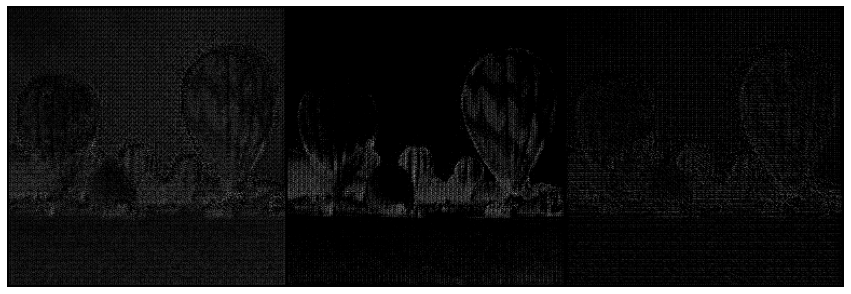

In [19]:
with torch.no_grad():
    # X = torch.ones(2, 1, 256, 256, device=device)
    im = netG(l_im.cuda().float())

    print(im.shape)

    im = im[6].cpu().detach()
    channels = make_grid(im.view(-1, 1, 256, 256), nrow=8)

plt.figure(figsize=(15, 14))

# plt.subplot(121)
plt.imshow(np.transpose(channels, axes=(1, 2, 0)))
plt.axis('off')

# plt.subplot(122)
# plt.imshow(lab2rgb(im))
# plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


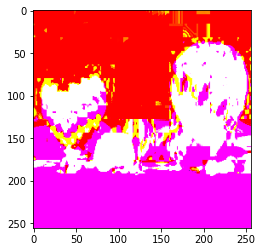

In [23]:
i = np.transpose(lab_im, axes=(1, 2, 0))
plt.imshow(i)

In [24]:
class Discriminator(nn.Module):

    def __init__(self, pad=(0, 1, 0, 1)):
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(OrderedDict([
            ('conv1', nn.Sequential(
                # Input size -> (nc) x 256 x 256
                nn.Conv2d(in_channels=nc, out_channels=ndf, kernel_size=4, stride=1, bias=False),
                nn.ReplicationPad2d(padding=(0, 3, 0, 3)),
                nn.LeakyReLU(negative_slope=0.2)
            )),
            ('conv2', nn.Sequential(
                #State size -> (ndf) x 256 x 256
                nn.Conv2d(in_channels=ndf, out_channels=ndf * 2, kernel_size=4, stride=2, bias=False),
                nn.ReplicationPad2d(padding=pad),
                nn.BatchNorm2d(ndf * 2),
                nn.LeakyReLU(negative_slope=0.2)
            )),
            ('conv3', nn.Sequential(
                # State size -> (ndf * 2) x 128 x 128
                nn.Conv2d(in_channels=ndf * 2, out_channels=ndf * 4, kernel_size=4, stride=2, bias=False),
                nn.ReplicationPad2d(padding=pad),
                nn.BatchNorm2d(ndf * 4),
                nn.LeakyReLU(negative_slope=0.2)
            )),
            ('conv4', nn.Sequential(
                # State size -> (ndf * 4) x 64 x 64
                nn.Conv2d(in_channels=ndf * 4, out_channels=ndf * 8, kernel_size=4, stride=2, bias=False),
                nn.ReplicationPad2d(padding=pad),
                nn.BatchNorm2d(ndf * 8),
                nn.LeakyReLU(negative_slope=0.2)
            )),
            ('conv5', nn.Sequential(
                # State size -> (ndf * 8) x 32 x 32
                nn.Conv2d(in_channels=ndf * 8, out_channels=ndf * 4, kernel_size=4, stride=2, bias=False),
                nn.ReplicationPad2d(padding=pad),
                nn.BatchNorm2d(ndf * 4),
                nn.LeakyReLU(negative_slope=0.2)
            )),
            ('conv6', nn.Sequential(
                # State size -> (ndf * 4) x 16 x 16
                nn.Conv2d(in_channels=ndf * 4, out_channels=ndf * 2, kernel_size=4, stride=2, bias=False),
                nn.ReplicationPad2d(padding=pad),
                nn.BatchNorm2d(ndf * 2),
                nn.LeakyReLU(negative_slope=0.2)
            )),
            ('conv7', nn.Sequential(
                # State size -> (ndf * 2) x 8 x 8
                nn.Conv2d(in_channels=ndf * 2, out_channels=ndf, kernel_size=4, stride=2, bias=False),
                nn.ReplicationPad2d(padding=pad),
                nn.BatchNorm2d(ndf),
                nn.LeakyReLU(negative_slope=0.2)
            )),
            ('conv8', nn.Sequential(
                # State size -> (ndf) x 4 x 4
                nn.Conv2d(in_channels=ndf, out_channels=nz, kernel_size=4, stride=2, bias=False),
                nn.Sigmoid()
                # State size -> (nz) x 1 x 1
            ))
        ]))

    def forward(self, x):
        return self.main(x)


netD = Discriminator().to(device)
netD.apply(weights_init)
netD

Discriminator(
  (main): Sequential(
    (conv1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): ReplicationPad2d((0, 3, 0, 3))
      (2): LeakyReLU(negative_slope=0.2)
    )
    (conv2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), bias=False)
      (1): ReplicationPad2d((0, 1, 0, 1))
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.2)
    )
    (conv3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), bias=False)
      (1): ReplicationPad2d((0, 1, 0, 1))
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.2)
    )
    (conv4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), bias=False)
      (1): ReplicationPad2d((0, 1, 0, 1))
      (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_ru

In [26]:
with torch.no_grad():
    X = torch.ones(5, 3, 256, 256, device=device)
    print(netD(X).shape)

torch.Size([5, 1, 1, 1])


In [25]:
# Handle multi-gpu if desired.
if (device.type == 'cuda') and (ngpu >= 1):
    # netG = nn.DataParallel(netG, list(range(ngpu)))
    # netD = nn.DataParallel(netD, list(range(ngpu)))
    pass

In [26]:
criterion = nn.BCELoss().to(device)

optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=weight_decay)
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=weight_decay)

In [29]:
# Establish convention for real and fake labels during training.
# Deep neural networks normally tend to produce extremely confident outputs
# when used in classification. It is shown that replacing the 0 and 1 targets
# for a classifier with smoothed values, like .1 and .9 is an excellent regular-
# izer for convolutional networks. Salimans et al demonstrated that
# one-sided label smoothing will encourage the discriminator to estimate soft
# probabilities and reduce the vulnerability of GANs to adversarial examples.
# In this technique we smooth only the positive labels to 0.9, leaving negative
# labels set to 0.
real_label = 0.9
fake_label = 0

## Training the DCGAN for Image Colorization

In [36]:
WINDOW_NAME = 'Fake Result'
cv2.namedWindow(WINDOW_NAME, flags=cv2.WINDOW_NORMAL)
cv2.resizeWindow(WINDOW_NAME, 1292, 518)

torch.cuda.empty_cache()

G_losses = []
D_losses = []

epochs = 2
batch_limit = 4000
is_destroy = False

start = time.time()

for i in range(epochs):
    i += 1

    for batch, (X, y) in enumerate(zip(lab_loader, l_loader)):
        batch += 1

        netD.zero_grad()
        # Train D with REAL IMAGES.
        X = X[0].to(device).float()
        y = y[0].to(device).float()

        labels = torch.full((batch_size, ), fill_value=real_label, device=device, dtype=torch.float32)

        out = netD(X).view(-1)

        errD_real = criterion(out, labels)

        errD_real.backward()
        D_x = out.mean().item()

        # Train D with FAKE IMAGES from G.
        fake = netG(y)
        # fake = torch.cat([y, fake], dim=1)

        labels.fill_(fake_label)

        out = netD(fake.detach()).view(-1)
        errD_fake = criterion(out, labels)

        errD_fake.backward()
        D_G_z1 = out.mean().item()

        errD = errD_real + errD_fake

        # Update D.
        optimizerD.step()

        netG.zero_grad()

        # Update G.
        labels.fill_(real_label)

        out = netD(fake).view(-1)

        errG = criterion(out, labels)

        errG.backward()
        D_G_z2 = out.mean().item()

        optimizerG.step()

        # Output training stats.
        if batch % 100 == 0 or batch == 1:
            print('[%d/%d] [%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f \tD(G(z)): %.4f / %.4f'
                  % (i, epochs, batch, batch_limit, errD, errG, D_x, D_G_z1, D_G_z2))

            D_losses.append(errD.item())
            G_losses.append(errG.item())


        grid = make_grid(fake.detach().cpu(), nrow=5, normalize=True).numpy()
        grid = cv2.cvtColor(np.transpose(grid, axes=(1, 2, 0)), code=cv2.COLOR_LAB2RGB)

        cv2.imshow(WINDOW_NAME, grid)

        if cv2.waitKey(1) & 0xFF == 27:
            is_destroy = True
            break

            # for param_group in optimizerG.param_groups:
            #     param_group['lr']: lr // 10
            #
            # for param_group in optimizerD.param_groups:
            #     param_group['lr']: lr // 10

        if batch == batch_limit:
            break

    if is_destroy:
        cv2.destroyWindow(WINDOW_NAME)
        break


duration = time.time() - start
print(f'Duration to execute: {duration / 60:.4f} minutes')

[1/2] [1/4000]	Loss_D: 0.4702	Loss_G: 3.0185	D(x): 0.8730 	D(G(z)): 0.1156 / 0.0352
Duration to execute: 0.3868 minutes


In [20]:
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [21]:
torch.cuda.empty_cache()

batch_limit = 2000

losses = []
epochs = 4

WINDOW_NAME = "Places365 Frames"

cv2.namedWindow(WINDOW_NAME, flags=cv2.WINDOW_NORMAL)
cv2.resizeWindow(WINDOW_NAME, width=1280, height=256)

is_destroy = False

start = time.time()

netG.train()

for i in range(epochs):
    i += 1

    for batch, (x, y) in enumerate(zip(lab_loader, l_loader)):
        batch += 1

        optimizer.zero_grad()

        x = x[0].to(device).float()
        y = y[0].to(device).float()

        out = netG(y)
        loss = criterion(out, x)

        losses.append(loss)

        if batch == 1 or batch % 200 == 0:
            print(f'Epoch: {i}, Batch: {batch} -> Loss: {loss}')

        grid = make_grid(out.detach().cpu(), nrow=10, normalize=True).numpy()
        # grid = cv2.cvtColor(np.transpose(grid, axes=(1, 2, 0)), code=cv2.COLOR_BGR2RGB)
        grid = lab2rgb(grid) * 255

        cv2.imshow(WINDOW_NAME, grid)

        if cv2.waitKey(1) & 0xFF == 27:
            is_destroy = True
            break

        loss.backward()
        optimizer.step()

        if batch_limit == batch:
            break

    if is_destroy:
        cv2.destroyWindow(WINDOW_NAME)
        break

duration = time.time() - start
print(f'Duration to execute: {duration / 60:.4f} minutes')

Epoch: 1, Batch: 1 -> Loss: 1376.1260986328125
Duration to execute: 1.1568 minutes


In [ ]:
plt.plot(D_losses, label='Discriminator')
plt.plot(G_losses, label='Generator')
plt.legend()
plt.xlabel("EPOCHS")
plt.ylabel('LOSSES')

In [39]:
PATH_G = '../../state_dict/net_g_net.pth'
PATH_D = '../../state_dict/net_d_net.pth'

torch.save(netG.state_dict(), PATH_G)
# netG.load_state_dict(torch.load(PATH_G))

torch.save(netD.state_dict(), PATH_D)
# netD.load_state_dict(torch.load(PATH_D))


In [40]:
img_size = (256, 256)

@torch.no_grad()
def view_gan(im):

    netG.eval()

    print(im.shape)

    image = netG(im.to(device).float())
    # image = torch.cat([im, image], dim=1)

    # l_channel, a_channel, b_channel = (image[:, 0], image[:, 1], image[:, 2])
    # image = torch.stack([(l_channel + 1) / 2 * 100, a_channel * 110, b_channel * 110], dim=1)

    image = lab2rgb(image.cpu().numpy().reshape(-1, *img_size))
    return image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 1, 256, 256])


Text(0.5, 1.0, 'MODEL GENERATED')

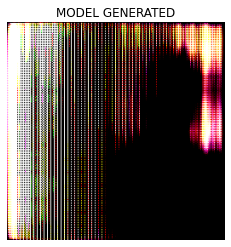

In [41]:
IMG_INDEX = 6

img = l_im[IMG_INDEX]
img = view_gan(img.view(-1, 1, *img_size).cuda().float())

plt.imshow(img * 255)
plt.axis('off')
plt.title('MODEL GENERATED')

In [35]:
cv2.destroyAllWindows()